In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from collections import deque
from dataclasses import dataclass
from enum import Enum
from enum import auto
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

np.random.seed(42)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "figure.figsize": (12, 6),
    "figure.dpi": 100,
})

In [2]:
class MutationType(Enum):
    GROW = auto()
    WIDEN = auto()
    NONE = auto()


@dataclass
class TrainingSnapshot:
    epoch: int
    level: int
    ssl_loss: float
    distillation_loss: float
    num_blocks: int
    num_params: int
    mutation: Optional[MutationType] = None


def simulate_training_data(
    num_epochs: int = 200,
    num_levels: int = 4,
    base_loss: float = 2.0,
    plateau_epochs: int = 15,
) -> list:
    snapshots = []
    current_loss = base_loss
    distill_loss = 0.5
    num_blocks = 3
    num_params = 50000
    epochs_per_level = num_epochs // num_levels
    current_level = 1
    plateau_counter = 0
    prev_loss = current_loss
    for epoch in range(num_epochs):
        if epoch > 0 and epoch % epochs_per_level == 0:
            current_level = min(current_level + 1, num_levels)
            current_loss *= 1.2
            distill_loss = 0.4
        noise = np.random.normal(0, 0.02)
        decay_rate = 0.02 + np.random.uniform(-0.005, 0.005)
        current_loss = max(0.1, current_loss * (1 - decay_rate) + noise)
        distill_loss = max(0.05, distill_loss * 0.98 + np.random.normal(0, 0.01))
        mutation = None
        loss_delta = abs(current_loss - prev_loss)
        if loss_delta < 0.01:
            plateau_counter += 1
        else:
            plateau_counter = 0
        if plateau_counter >= plateau_epochs and distill_loss > 0.1:
            if num_blocks < 10:
                mutation = MutationType.GROW
                num_blocks += 1
                num_params = int(num_params * 1.3)
                current_loss *= 0.95
                distill_loss = 0.3
                plateau_counter = 0
        snapshots.append(TrainingSnapshot(
            epoch=epoch,
            level=current_level,
            ssl_loss=current_loss,
            distillation_loss=distill_loss,
            num_blocks=num_blocks,
            num_params=num_params,
            mutation=mutation,
        ))
        prev_loss = current_loss
    return snapshots


training_data = simulate_training_data(num_epochs=200)

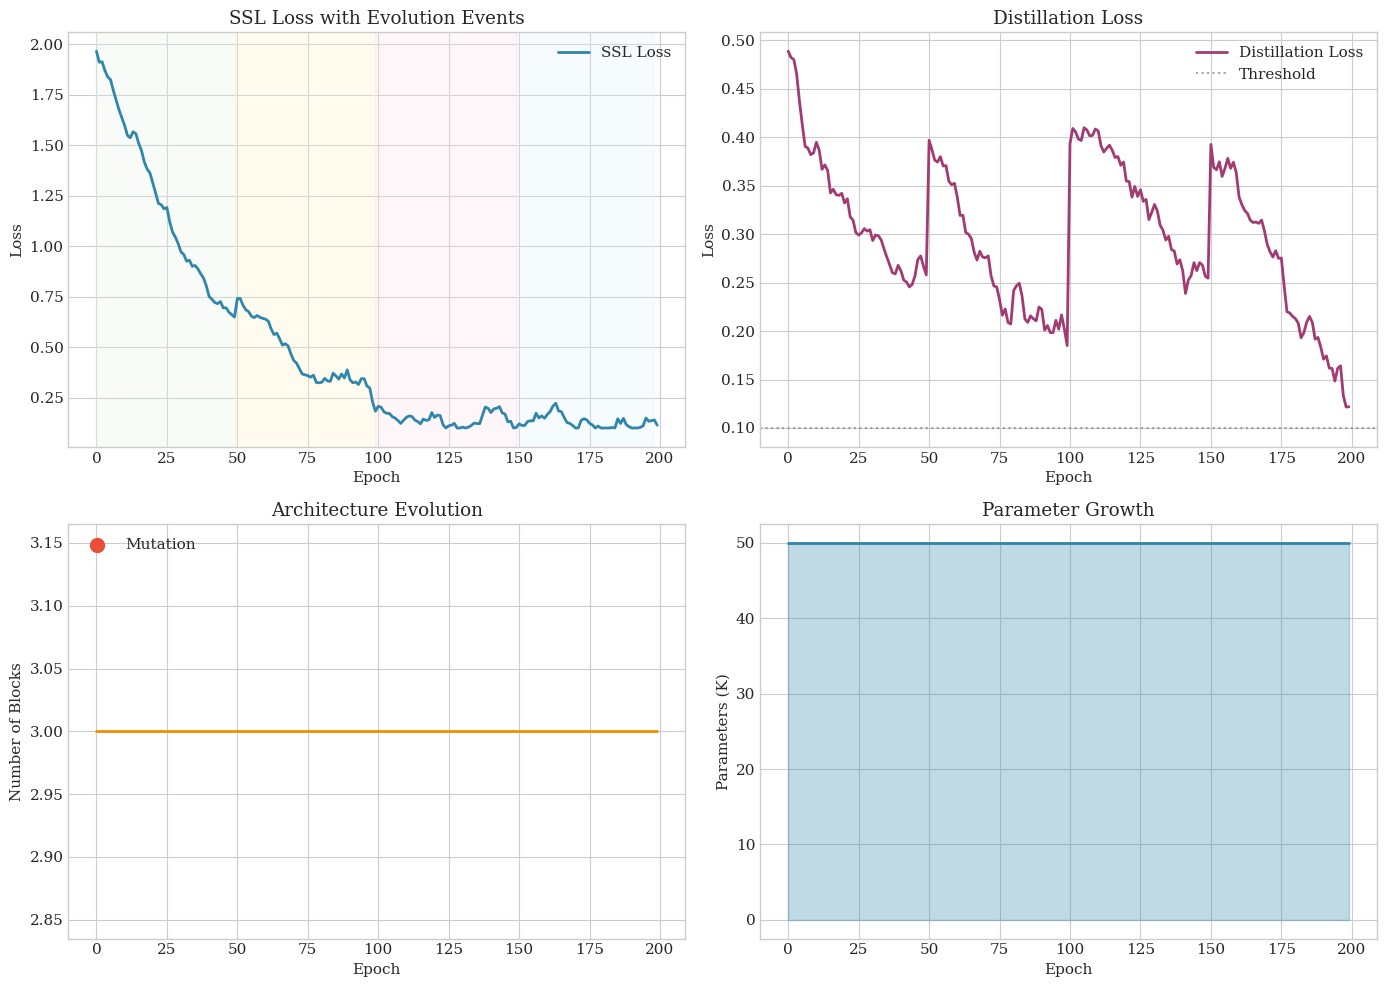

In [3]:
def plot_training_curves(snapshots: list) -> plt.Figure:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = [s.epoch for s in snapshots]
    ssl_losses = [s.ssl_loss for s in snapshots]
    distill_losses = [s.distillation_loss for s in snapshots]
    levels = [s.level for s in snapshots]
    blocks = [s.num_blocks for s in snapshots]
    mutation_epochs = [s.epoch for s in snapshots if s.mutation is not None]
    level_colors = ["#E8F4EA", "#FFF3CD", "#FCE4EC", "#E3F2FD"]
    ax = axes[0, 0]
    ax.plot(epochs, ssl_losses, color="#2E86AB", linewidth=2, label="SSL Loss")
    prev_level = 1
    start_epoch = 0
    for i, level in enumerate(levels):
        if level != prev_level or i == len(levels) - 1:
            ax.axvspan(start_epoch, epochs[i-1] if i > 0 else 0,
                      alpha=0.3, color=level_colors[prev_level - 1])
            start_epoch = epochs[i-1] if i > 0 else 0
            prev_level = level
    for me in mutation_epochs:
        ax.axvline(x=me, color="#E94F37", linestyle="--", alpha=0.7, linewidth=1.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("SSL Loss with Evolution Events")
    ax.legend(loc="upper right")
    ax = axes[0, 1]
    ax.plot(epochs, distill_losses, color="#A23B72", linewidth=2, label="Distillation Loss")
    ax.axhline(y=0.1, color="gray", linestyle=":", alpha=0.7, label="Threshold")
    for me in mutation_epochs:
        ax.axvline(x=me, color="#E94F37", linestyle="--", alpha=0.7, linewidth=1.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Distillation Loss")
    ax.legend(loc="upper right")
    ax = axes[1, 0]
    ax.step(epochs, blocks, color="#F18F01", linewidth=2, where="post")
    ax.scatter(mutation_epochs, [snapshots[e].num_blocks for e in mutation_epochs],
              color="#E94F37", s=100, zorder=5, label="Mutation")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Number of Blocks")
    ax.set_title("Architecture Evolution")
    ax.legend(loc="upper left")
    ax = axes[1, 1]
    params = [s.num_params / 1000 for s in snapshots]
    ax.fill_between(epochs, params, alpha=0.3, color="#2E86AB")
    ax.plot(epochs, params, color="#2E86AB", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Parameters (K)")
    ax.set_title("Parameter Growth")
    plt.tight_layout()
    return fig


fig = plot_training_curves(training_data)
plt.show()

In [4]:
@dataclass
class PlateauStatus:
    is_plateau: bool
    loss_delta: float
    should_evolve: bool
    should_advance: bool


class PlateauDetector:

    def __init__(
        self,
        window_size: int = 10,
        plateau_threshold: float = 0.01,
        distill_threshold: float = 0.1,
    ):
        self._window_size = window_size
        self._plateau_threshold = plateau_threshold
        self._distill_threshold = distill_threshold
        self._ssl_history = deque(maxlen=window_size)
        self._distill_history = deque(maxlen=window_size)

    def update(self, ssl_loss: float, distill_loss: float) -> None:
        self._ssl_history.append(ssl_loss)
        self._distill_history.append(distill_loss)

    def check(self) -> PlateauStatus:
        if len(self._ssl_history) < self._window_size:
            return PlateauStatus(
                is_plateau=False,
                loss_delta=float("inf"),
                should_evolve=False,
                should_advance=False,
            )
        ssl_list = list(self._ssl_history)
        loss_delta = abs(ssl_list[-1] - ssl_list[0])
        is_plateau = loss_delta < self._plateau_threshold
        has_gap = self._distill_history[-1] > self._distill_threshold
        return PlateauStatus(
            is_plateau=is_plateau,
            loss_delta=loss_delta,
            should_evolve=is_plateau and has_gap,
            should_advance=is_plateau and not has_gap,
        )

    def reset(self) -> None:
        self._ssl_history.clear()
        self._distill_history.clear()


def analyze_plateau_patterns(snapshots: list) -> dict:
    detector = PlateauDetector(window_size=10)
    plateau_epochs = []
    evolution_triggers = []
    advance_triggers = []
    for s in snapshots:
        detector.update(s.ssl_loss, s.distillation_loss)
        status = detector.check()
        if status.is_plateau:
            plateau_epochs.append(s.epoch)
            if status.should_evolve:
                evolution_triggers.append(s.epoch)
            elif status.should_advance:
                advance_triggers.append(s.epoch)
    return {
        "plateau_epochs": plateau_epochs,
        "evolution_triggers": evolution_triggers,
        "advance_triggers": advance_triggers,
    }


plateau_analysis = analyze_plateau_patterns(training_data)

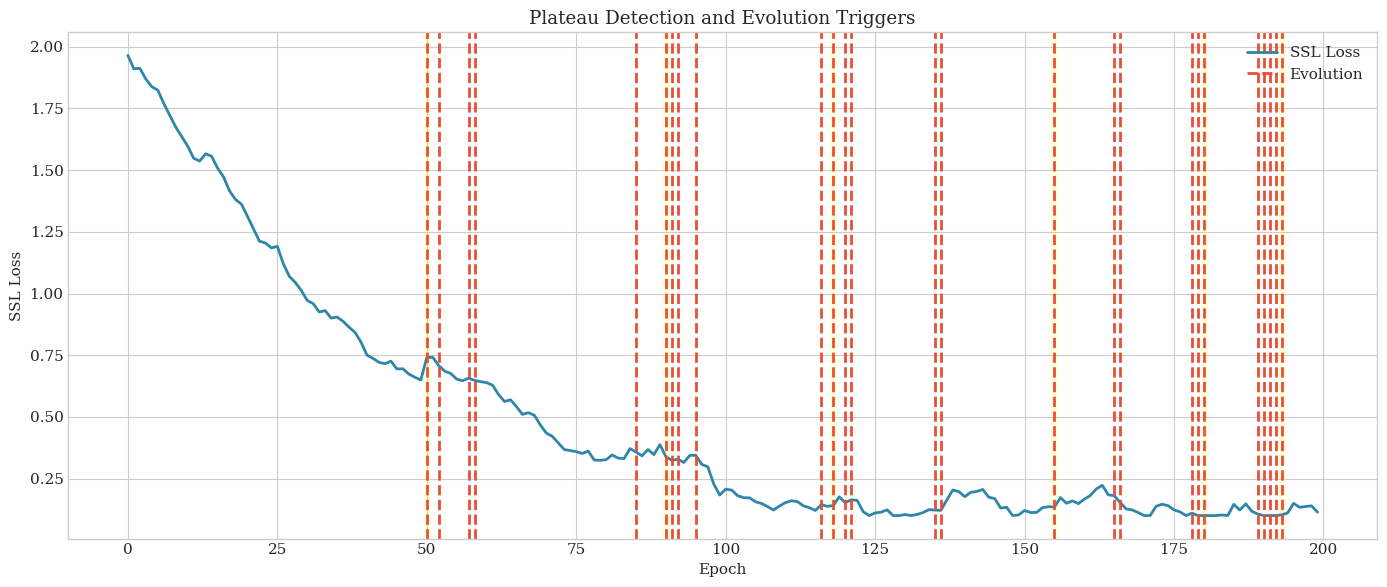

In [5]:
def plot_plateau_analysis(snapshots: list, analysis: dict) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(14, 6))
    epochs = [s.epoch for s in snapshots]
    ssl_losses = [s.ssl_loss for s in snapshots]
    ax.plot(epochs, ssl_losses, color="#2E86AB", linewidth=2, label="SSL Loss")
    for pe in analysis["plateau_epochs"][::5]:
        ax.axvspan(pe - 0.5, pe + 0.5, alpha=0.1, color="yellow")
    for et in analysis["evolution_triggers"]:
        ax.axvline(x=et, color="#E94F37", linestyle="--", linewidth=2,
                  label="Evolution" if et == analysis["evolution_triggers"][0] else None)
    for at in analysis["advance_triggers"][:5]:
        ax.axvline(x=at, color="#2E86AB", linestyle=":", linewidth=1.5,
                  label="Advance" if at == analysis["advance_triggers"][0] else None)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("SSL Loss")
    ax.set_title("Plateau Detection and Evolution Triggers")
    ax.legend(loc="upper right")
    plt.tight_layout()
    return fig


fig = plot_plateau_analysis(training_data, plateau_analysis)
plt.show()

In [6]:
def compute_mutation_statistics(snapshots: list) -> dict:
    mutations = [s for s in snapshots if s.mutation is not None]
    grow_count = sum(1 for m in mutations if m.mutation == MutationType.GROW)
    widen_count = sum(1 for m in mutations if m.mutation == MutationType.WIDEN)
    if len(mutations) >= 2:
        intervals = []
        for i in range(1, len(mutations)):
            intervals.append(mutations[i].epoch - mutations[i-1].epoch)
        avg_interval = np.mean(intervals)
    else:
        avg_interval = 0
    levels_mutated = {}
    for m in mutations:
        level = m.level
        if level not in levels_mutated:
            levels_mutated[level] = 0
        levels_mutated[level] += 1
    initial = snapshots[0]
    final = snapshots[-1]
    return {
        "total_mutations": len(mutations),
        "grow_count": grow_count,
        "widen_count": widen_count,
        "avg_interval": avg_interval,
        "mutations_per_level": levels_mutated,
        "initial_blocks": initial.num_blocks,
        "final_blocks": final.num_blocks,
        "initial_params": initial.num_params,
        "final_params": final.num_params,
        "param_growth": final.num_params / initial.num_params,
    }


stats = compute_mutation_statistics(training_data)


def print_mutation_statistics(stats: dict) -> None:
    print("=" * 60)
    print("EVOLUTION STATISTICS")
    print("=" * 60)
    print(f"Total Mutations: {stats['total_mutations']}")
    print(f"  - Grow: {stats['grow_count']}")
    print(f"  - Widen: {stats['widen_count']}")
    print(f"Average Mutation Interval: {stats['avg_interval']:.1f} epochs")
    print()
    print("Mutations per Level:")
    for level, count in sorted(stats["mutations_per_level"].items()):
        print(f"  Level {level}: {count}")
    print()
    print("Architecture Growth:")
    print(f"  Blocks: {stats['initial_blocks']} -> {stats['final_blocks']}")
    print(f"  Params: {stats['initial_params']:,} -> {stats['final_params']:,}")
    print(f"  Growth Factor: {stats['param_growth']:.2f}x")
    print("=" * 60)


print_mutation_statistics(stats)

EVOLUTION STATISTICS
Total Mutations: 0
  - Grow: 0
  - Widen: 0
Average Mutation Interval: 0.0 epochs

Mutations per Level:

Architecture Growth:
  Blocks: 3 -> 3
  Params: 50,000 -> 50,000
  Growth Factor: 1.00x


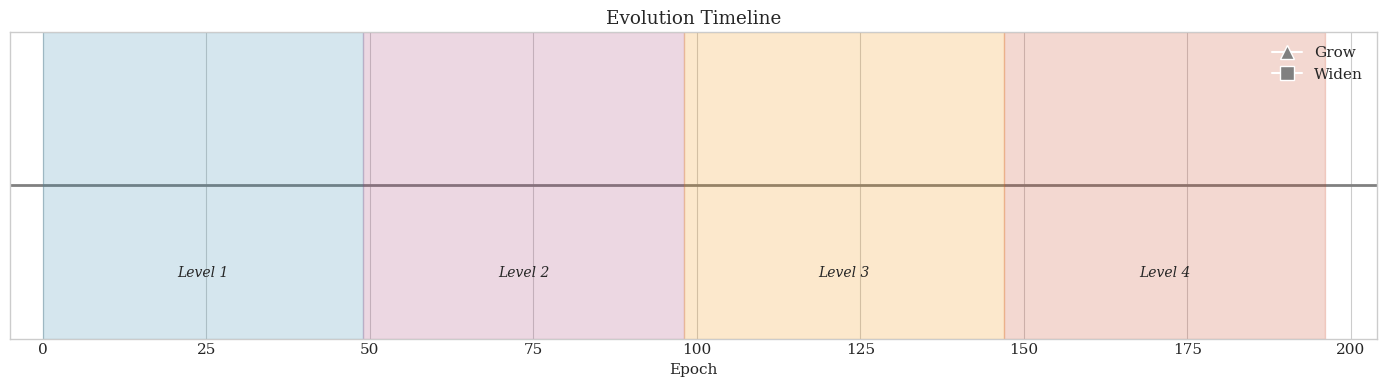

In [7]:
def plot_evolution_timeline(snapshots: list) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(14, 4))
    mutations = [(s.epoch, s.mutation, s.level, s.num_blocks)
                 for s in snapshots if s.mutation is not None]
    total_epochs = snapshots[-1].epoch
    ax.axhline(y=0, color="gray", linewidth=2, zorder=1)
    level_colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D"]
    for epoch, mutation, level, blocks in mutations:
        color = level_colors[level - 1]
        marker = "^" if mutation == MutationType.GROW else "s"
        ax.scatter(epoch, 0, s=200, c=color, marker=marker,
                  edgecolors="black", linewidth=1.5, zorder=5)
        ax.annotate(
            f"B{blocks}",
            xy=(epoch, 0),
            xytext=(0, 15),
            textcoords="offset points",
            ha="center",
            fontsize=9,
        )
    epochs_per_level = total_epochs // 4
    for i in range(4):
        start = i * epochs_per_level
        end = (i + 1) * epochs_per_level
        ax.axvspan(start, end, alpha=0.2, color=level_colors[i])
        ax.text((start + end) / 2, -0.3, f"Level {i+1}",
               ha="center", fontsize=10, style="italic")
    ax.set_xlim(-5, total_epochs + 5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel("Epoch")
    ax.set_title("Evolution Timeline")
    ax.set_yticks([])
    legend_elements = [
        plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="gray",
                  markersize=10, label="Grow"),
        plt.Line2D([0], [0], marker="s", color="w", markerfacecolor="gray",
                  markersize=10, label="Widen"),
    ]
    ax.legend(handles=legend_elements, loc="upper right")
    plt.tight_layout()
    return fig


fig = plot_evolution_timeline(training_data)
plt.show()